## Modelling Corn Plant Disease Classification with EfficientNet B2
# Summary & How to Use

The use of this web utlity platform is to let users of the internet upload pictures of corn plant images, have it be classified and get a determination output as to what kind of disease it shows. The platform will be UI/UX friendly for everyone of age, showing relevancy of informations about the indicated diseases. It is an integrated system of web development and AI modelling.

### Setting up Parameters and Libraries

In [1]:
%%bash

python3 -m venv --system-site-packages ./venv

In [2]:
%%bash

source ./venv/bin/activate
pip install --upgrade pip
#pip list

In [3]:
 
%pip install --upgrade -q Pillow
%pip install -q tensorflow
%pip install -q keras
%pip install -q split-folders

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import numpy as np
import splitfolders
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, GlobalAveragePooling2D, Dropout



2022-04-23 06:20:39.558928: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-23 06:20:39.558956: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
base_path = "./data"
data_dir = base_path + "/corn"
train_dir = base_path + "/train"
test_dir = base_path + "/test"
valid_dir = base_path + "/val"
diseases = os.listdir(data_dir)


In [6]:
# the ratio to split the data which goes into 60% training, 20% validation, 20% test
splitfolders.ratio(data_dir, base_path, seed=1337, ratio=(0.6, 0.2, 0.2), group_prefix=None)

print(diseases)
print("\nTotal disease classes are: {}".format(len(diseases)))

['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy']

Total disease classes are: 4


### Exploring the Data

In [7]:
# Exploring the data gathered
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(data_dir + '/' + disease))

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["No. of images"])
print(img_per_class)

n_train = 0
for val in nums.values():
    n_train += val
print(f"\nThere are {n_train} images in total for training")

                                                    No. of images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot            513
Corn_(maize)___Common_rust_                                  1192
Corn_(maize)___Northern_Leaf_Blight                           985
Corn_(maize)___healthy                                       1162

There are 3852 images in total for training


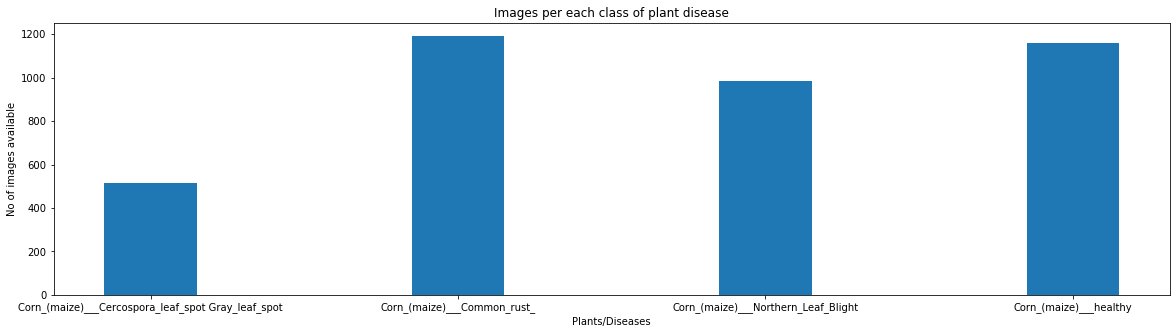

In [47]:
index = [n for n in range(4)]
plt.figure(figsize=(20,5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases')
plt.ylabel('No of images available')
plt.xticks(index, diseases)
plt.title('Images per each class of plant disease')
plt.savefig('assets/Distribution of Data.png')

### Preparing the Data for Training

In any machine learning project, it is critical to set up a trustworthy validation scheme, in order to properly evaluate and compare models. This is especially true if the dataset is small which is the case of this project. For a typical image classification problem, the standard approach is to take a deep CNN model (such as the most popular EffcientNet) trained on ImageNet, replace the last layer so that the output dimension equals the target's dimension, and fine tune it on the specific dataset.

In [9]:
batch_size = 8
img_height = 260
img_width = 260

# Generating batches of real-time augmented images
train_gen = ImageDataGenerator(
    rescale=1/255.0, validation_split=0, fill_mode="nearest", 
    rotation_range=40, horizontal_flip=True, shear_range=0.2, zoom_range=0.2,
    preprocessing_function=preprocess_input
)
valid_gen = ImageDataGenerator(rescale=1/255.0, validation_split=0)
test_gen = ImageDataGenerator(rescale=1/255.0)

train_gen
valid_gen
test_gen

train_data = train_gen.flow_from_directory(directory=train_dir, target_size=(img_width, img_height), 
    color_mode='rgb', batch_size=batch_size, shuffle=True, class_mode="categorical")

valid_data = valid_gen.flow_from_directory(directory=valid_dir, target_size=(img_width, img_height), 
    color_mode='rgb', batch_size=batch_size, shuffle=True, class_mode="categorical")

test_data = test_gen.flow_from_directory(directory=test_dir, target_size=(img_width, img_height), 
    color_mode='rgb', batch_size=batch_size, shuffle=True, class_mode="categorical")

train_data
valid_data
test_data

# Pulling out images and labels from sets for visualization
train_imgs, train_labels = next(train_data)
valid_imgs, valid_labels = next(valid_data)
test_imgs, test_labels = next(test_data)

print(train_data.class_indices)
# for data_batch, labels_batch in train_data:
#     print("Train Data Shape: ", data_batch.shape)
#     print("Train Label Shape: ", labels_batch.shape)
#     break

Found 2310 images belonging to 4 classes.
Found 769 images belonging to 4 classes.
Found 773 images belonging to 4 classes.
{'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 0, 'Corn_(maize)___Common_rust_': 1, 'Corn_(maize)___Northern_Leaf_Blight': 2, 'Corn_(maize)___healthy': 3}


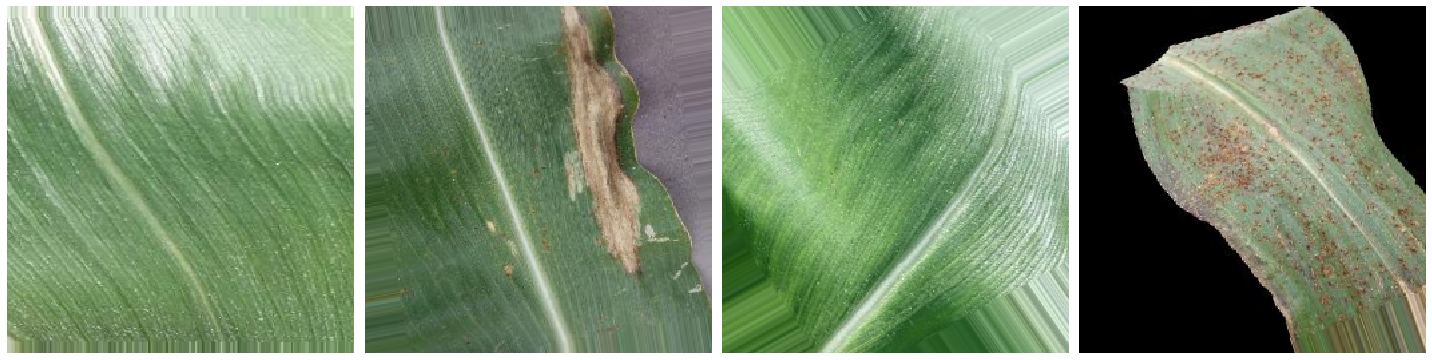

In [45]:
fig, axes = plt.subplots(1, 4, figsize=(20,20))
axes = axes.flatten()
for img, ax in zip(train_imgs[:4], axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.savefig('assets/Augmented Images Preview.png')
plt.show()

### Model Creation

In [11]:
!mkdir -p saved-model-b2
checkpoint = ModelCheckpoint('saved-model-b2/best_model', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=0.001)

In [12]:
effinet_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(260,260,3))

x = GlobalAveragePooling2D(name="avg_pool")(effinet_model.output)
x = BatchNormalization()(x)
x = Dropout(0.2, name="top_dropout")(x)
predictors = Dense(4, activation="softmax", name="predictions")(x)
final_effinet_model = Model(effinet_model.input, outputs=predictors)

# Freeze the pretrained weights
for layer in final_effinet_model.layers[:1]:
    layer.trainable = False

# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
final_effinet_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])



2022-04-23 06:20:52.530150: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-23 06:20:52.530195: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-23 06:20:52.530226: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (x250): /proc/driver/nvidia/version does not exist
2022-04-23 06:20:52.531728: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
final_effinet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 260, 260, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 260, 260, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 260, 260, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 261, 261, 3)  0           ['normalization[0][0]']      

In [14]:
image_batch, label_batch = next(iter(train_data))
feature_batch = effinet_model(image_batch)

validation_batch, val_label_batch = next(iter(valid_data))
valid_batch = effinet_model(validation_batch)

print(feature_batch.shape)
print(valid_batch.shape)


(8, 9, 9, 1408)
(8, 9, 9, 1408)


### Model Training

In [15]:
epochs = 15
hist = final_effinet_model.fit(train_data, epochs=epochs, validation_data=valid_data, callbacks=[checkpoint, earlystop])

Epoch 1/15
289/289 [==============================] - ETA: 0s - loss: 1.2181 - accuracy: 0.5268
Epoch 1: val_loss improved from inf to 1.73584, saving model to saved-model-b2/best_model
289/289 [==============================] - 1407s 5s/step - loss: 1.2181 - accuracy: 0.5268 - val_loss: 1.7358 - val_accuracy: 0.1170
Epoch 2/15
289/289 [==============================] - ETA: 0s - loss: 0.6491 - accuracy: 0.7558
Epoch 2: val_loss improved from 1.73584 to 0.99790, saving model to saved-model-b2/best_model
289/289 [==============================] - 1400s 5s/step - loss: 0.6491 - accuracy: 0.7558 - val_loss: 0.9979 - val_accuracy: 0.6320
Epoch 3/15
289/289 [==============================] - ETA: 0s - loss: 0.4809 - accuracy: 0.8203
Epoch 3: val_loss improved from 0.99790 to 0.35640, saving model to saved-model-b2/best_model
289/289 [==============================] - 1405s 5s/step - loss: 0.4809 - accuracy: 0.8203 - val_loss: 0.3564 - val_accuracy: 0.8674
Epoch 4/15
289/289 [===============

In [16]:
final_effinet_model.save('saved-model-b2/best_model')

2022-04-23 11:03:57.053742: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: saved-model-b2/best_model/assets


### Visualization of Model Training

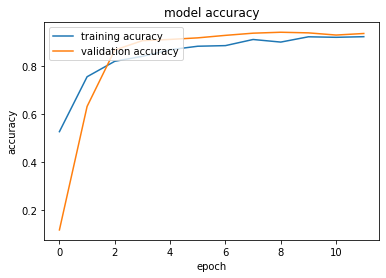

In [43]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["training acuracy", "validation accuracy"], loc="upper left")
    plt.savefig('assets/B2 Model Accuracy Plot History.png')
    plt.show()

plot_hist(hist)

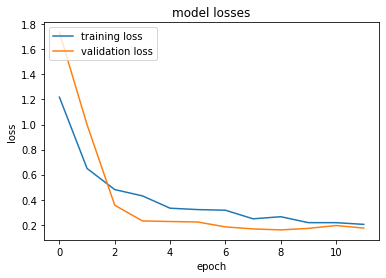

In [44]:
def plot_hist(hist):
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("model losses")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["training loss", "validation loss"], loc="upper left")
    plt.savefig('assets/B2 Model Loss Plot History.png')
    plt.show()

plot_hist(hist)

### Model Prediction Against Testing Data

In [19]:
final_effinet_model.evaluate(test_data)

97/97 [==============================] - 82s 848ms/step - loss: 0.1366 - accuracy: 0.9508


[0.1365722119808197, 0.9508408904075623]

In [20]:
predict_model = final_effinet_model.predict(test_data, verbose=2)
print("Prediction Result Shape: ", predict_model.shape)
predict_model

97/97 - 83s - 83s/epoch - 860ms/step
Prediction Result Shape:  (773, 4)


array([[9.9638051e-01, 2.1756785e-04, 1.2079889e-03, 2.1939559e-03],
       [1.5893915e-05, 9.9953628e-01, 9.3627051e-07, 4.4698251e-04],
       [9.9513948e-01, 2.6478125e-03, 1.8380800e-03, 3.7460518e-04],
       ...,
       [3.1382020e-04, 9.9963117e-01, 6.6967018e-06, 4.8404228e-05],
       [8.9224583e-01, 2.9506072e-02, 6.2156942e-02, 1.6091088e-02],
       [2.9181802e-01, 3.4816839e-02, 6.2709999e-01, 4.6265189e-02]],
      dtype=float32)

In [21]:
data_labels = sorted(train_data.class_indices.items(), key=lambda pair:pair[1])
print(data_labels)
data_labels = np.array([key.title() for key, value in data_labels])
print(data_labels)

data_labels[0] = 'Cercospora Leaf Spot (Gray Leaf Spot)'
data_labels[1] = 'Common Rust'
data_labels[2] = 'Northern Leaf Blight'
data_labels[3] = 'Healthy'

print(data_labels)

[('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 0), ('Corn_(maize)___Common_rust_', 1), ('Corn_(maize)___Northern_Leaf_Blight', 2), ('Corn_(maize)___healthy', 3)]
['Corn_(Maize)___Cercospora_Leaf_Spot Gray_Leaf_Spot'
 'Corn_(Maize)___Common_Rust_' 'Corn_(Maize)___Northern_Leaf_Blight'
 'Corn_(Maize)___Healthy']
['Cercospora Leaf Spot (Gray Leaf Spot)' 'Common Rust'
 'Northern Leaf Blight' 'Healthy']


In [28]:
predicted_ids = np.argmax(predict_model, axis=-1)
predicted_labels = data_labels[predicted_ids]
print(predicted_labels)

y_pred = np.argmax(predict_model, axis=1)
print(y_pred)

['Cercospora Leaf Spot (Gray Leaf Spot)' 'Common Rust'
 'Cercospora Leaf Spot (Gray Leaf Spot)' 'Healthy' 'Northern Leaf Blight'
 'Healthy' 'Common Rust' 'Cercospora Leaf Spot (Gray Leaf Spot)'
 'Common Rust' 'Cercospora Leaf Spot (Gray Leaf Spot)'
 'Northern Leaf Blight' 'Northern Leaf Blight' 'Common Rust'
 'Cercospora Leaf Spot (Gray Leaf Spot)' 'Healthy' 'Common Rust'
 'Common Rust' 'Cercospora Leaf Spot (Gray Leaf Spot)' 'Common Rust'
 'Cercospora Leaf Spot (Gray Leaf Spot)'
 'Cercospora Leaf Spot (Gray Leaf Spot)' 'Healthy'
 'Cercospora Leaf Spot (Gray Leaf Spot)' 'Healthy'
 'Cercospora Leaf Spot (Gray Leaf Spot)' 'Healthy' 'Common Rust' 'Healthy'
 'Healthy' 'Common Rust' 'Cercospora Leaf Spot (Gray Leaf Spot)' 'Healthy'
 'Cercospora Leaf Spot (Gray Leaf Spot)'
 'Cercospora Leaf Spot (Gray Leaf Spot)'
 'Cercospora Leaf Spot (Gray Leaf Spot)' 'Common Rust'
 'Northern Leaf Blight' 'Northern Leaf Blight' 'Northern Leaf Blight'
 'Common Rust' 'Northern Leaf Blight' 'Healthy' 'Healthy

In [23]:
# model = tf.keras.models.load_model('saved-model/best_model')
# model.summary()

[[20 32 20 32]
 [33 83 54 69]
 [26 62 41 68]
 [45 68 57 63]]


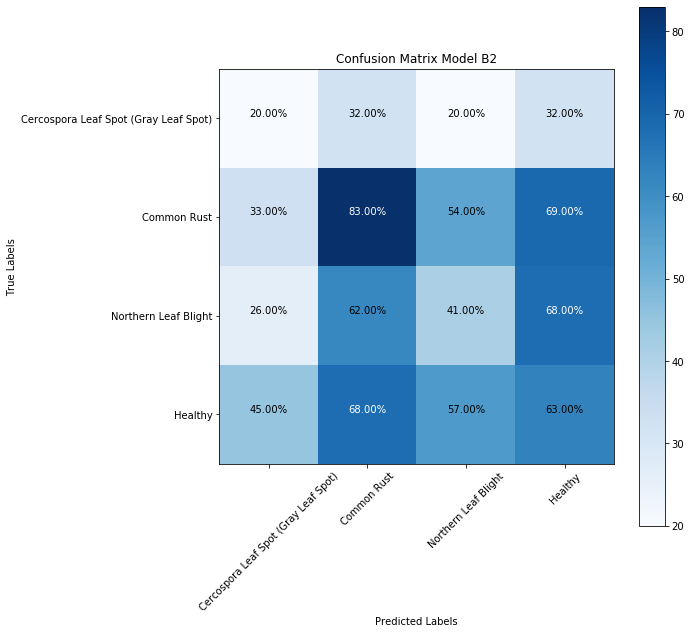

In [46]:
from sklearn.metrics import confusion_matrix
import itertools

cm = confusion_matrix(test_data.classes, y_pred) 
print(cm)

plt.figure(figsize=(10, 10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
tick_marks = np.arange(len(data_labels))
plt.xticks(tick_marks, data_labels, rotation=45)
plt.yticks(tick_marks, data_labels)
plt.title("Confusion Matrix Model B2")

# Inserting percentage strings inside each boxes
thresh = 0.8 * cm.max() / 1
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    str_percentage = '{:.2f}%'.format(cm[i, j])
    plt.text(j, i, str_percentage, horizontalalignment='center', verticalalignment='bottom', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.colorbar()
plt.savefig('assets/Confusion Matrix Model B2.png')
plt.show()

In [25]:
# true_label_ids = np.argmax(test_data, axis=-1)

# plt.figure(figsize=(10, 9))
# plt.subplots_adjust(hspace=0.5)
# for item in range((len(predicted_labels)-2)):
#     plt.subplot(6, 5, item + 1)
#     plt.imshow(test_data[item])
#     color = 'green' if predicted_ids[item] == true_label_ids[item] else 'red'
#     plt.title(predicted_labels[item].title(), color=color)
#     plt.axis('off')